# Exploration of the most mentioned USERS and BRANDS during MFW

In [15]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

from datetime import timedelta as td
from datetime import datetime

import seaborn as sns
sns.set(style='white', color_codes=True)
sns.set_context(rc={"font.family":"sans","font.size":24,"axes.titlesize":24,"axes.labelsize":24})

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


Let's start by importing the dataset containing the information about the user mentions

In [16]:
path = 'Twitter_Bins/Hashtags_Bin/MFW_17-25/MFW_user-mention.csv'
dataset = pd.read_csv(path,encoding='utf-8')

In [17]:
dataset.head()

,date,user,mentions,tweets
0,2020-02-17,01calandrarose,1,1
1,2020-02-17,0315lisamarie,0,1
2,2020-02-17,03181834,0,1
3,2020-02-17,0318st___,53,12
4,2020-02-17,0327lovelisa,0,1


We fill in all the missing values, adding zeros in tweets and mentions where missing

In [18]:
users = dataset.user.unique()

dataset['date'] = pd.to_datetime(dataset['date'], dayfirst=True)
#print(dataset['date'])

le = LabelEncoder()
le.fit(dataset['date'])
dataset['date'] = le.transform(dataset['date'])
datelist = dataset['date'].unique()

Reindexing the dataframe by date and user, in order to have zeros in the days where the user didn't receive any mention or didn't tweet anything. 

In [20]:
user_mention = dataset.set_index(['user','date']) #.reindex(pd.date_range(min(user_mention['date']), max(user_mention['date']), freq="D"))

new_index = np.array(np.meshgrid(users,datelist)).T.reshape(-1,2)


user_mention = user_mention.reindex(new_index, fill_value=0).reset_index()
user_mention.date = le.inverse_transform(user_mention.date)
user_mention.date = pd.to_datetime(user_mention.date, dayfirst=True)

user_mention

,user,date,mentions,tweets
0,01calandrarose,2020-02-17,1,1
1,01calandrarose,2020-02-18,0,1
2,01calandrarose,2020-02-19,0,4
3,01calandrarose,2020-02-20,0,1
4,01calandrarose,2020-02-21,0,0
...,...,...,...,...
922549,1500,2020-02-21,0,0
922550,1500,2020-02-22,0,0
922551,1500,2020-02-23,0,0
922552,1500,2020-02-24,0,0


In [21]:
user_mention.describe()

,mentions,tweets
count,922554.000000,922554.000000
mean,0.361985,0.292866
std,34.700967,2.040515
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,9795.000000,578.000000


We can see that most of the users received zero mentions during one day. Let's see how the mentions are distributed when we compute the sum of all received mentions for every user.

In [22]:
aggregated_mentions = user_mention.groupby('user').sum().sort_values('mentions',ascending = True).reset_index()
aggregated_mentions.describe()

,mentions,tweets
count,102506.000000,102506.000000
mean,3.257868,2.635797
std,253.393007,15.651725
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,73074.000000,2446.000000


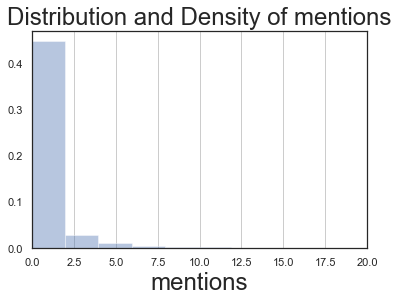

In [8]:
hist2 = sns.distplot(aggregated_mentions[aggregated_mentions['mentions']<100]['mentions'])
hist2.set_title('Distribution and Density of mentions')
plt.xlim(left=0,right=20)
plt.grid(axis='x')

In [9]:
aggregated_mentions = aggregated_mentions.sort_values('mentions', ascending=False)

As we can see most users weren't even mentioned most of the time. So we can shrink the dataset a lot, by getting rid of those users who havent been mentioned at least 20 times, which can be considered as a reasonable amount of mentions, in order to be relevant for our analysis. 

### Let's select only those users who have had at least 20 mentions throughout the whole week

First of all let's sum the mentions of the different users across the different days taken into account, then we filter out those who haven't had at least 20 mentions.

In [10]:
more_than_20 = aggregated_mentions['mentions'] > 20
most_mentioned = aggregated_mentions[more_than_20]
#Essendo raggruppati per user, user sarebbe l'indice, azzero l'indice e lo metto in una colonna
most_mentioned = most_mentioned.reset_index()
most_mentioned

,index,user,mentions,tweets
0,102505,poshmarkapp,73074,0
1,102504,ygofficialblink,22792,0
2,102503,prada,15073,1
3,102502,originalfunko,11580,0
4,102501,britishvogue,6874,30
...,...,...,...,...
736,101791,catrionaelisa,21,0
737,101795,saru_maini,21,2
738,101796,wfto_fairtrade,21,0
739,101797,trf_stories,21,1


## We select the users corresponding to the brands that exhibited during the MFW

In [11]:
milan_brands = pd.read_csv('./MIFW.csv', sep=';')[0:54]
#convert all usernames into lowercase
milan_brands['TWITTER'] = milan_brands['TWITTER'].str.lower()
milan_brands['DAY'] = milan_brands['DAY'].apply(str)
milan_brands['DAY'] = milan_brands['DAY'].apply(lambda s : s.split('-')[0])
milan_brands['DAY'] = milan_brands['DAY'].apply(int)
milan_brands

,BRAND,DAY,HOUR,LOCATION,INSTAGRAM,NOTE,TWITTER
0,GILBERTO CALZOLARI,19,09:30,VIA DELLA LIBERAZIONE ANG. VIA MELCHIORRE GIOIA,gilbertocalzolari_official,NaN,gilcalzolari
1,MARCO RAMBALDI,19,10:30,"VIA TURATI, 34",marcorambaldi_,NaN,NaN
2,CALCATERRA,19,11:30,"VIA SAN GREGORIO, 29",calcaterrad,NaN,NaN
3,ULTRÀCHIC,19,12:30,PIAZZA DUOMO - SCALONE ARENGARIO,ultrachic_official,NaN,ultrachicmilano
4,ARTHUR ARBESSER,19,14:00,"VIA GAUDENZIO FANTOLI, 15/1I",arthurarbesser,fuori dalla circonvallazione,NaN
5,GUCCI,19,15:00,"VIA MECENATE, 77",gucci,fuori dalla circonvallazione,gucci
6,ALBERTA FERRETTI,19,16:00,VIA MECENATE 88/A,albertaferretti,fuori dalla circonvallazione,albertaferretti
7,N°21,19,17:00,"VIA ARCHIMEDE, 26",numeroventuno,NaN,numeroventuno
8,JIL SANDER,19,18:00,"VIA BRAMANTE,42",jilsander,NaN,jilsanderpr
9,MONCLER,19,19:00,"VIALE MOLISE,70",moncler,fuori dalla circonvallazione,moncler


In [12]:
#select users that exhibited during the fashion week
mfw_most_mentioned = most_mentioned[most_mentioned['user'].isin(milan_brands['TWITTER'])]
mfw_mention = user_mention[user_mention['user'].isin(milan_brands['TWITTER'])]
mfw_mention = mfw_mention[mfw_mention['user'].isin(mfw_most_mentioned['user'])]
mfw_mention.head(15)

,user,date,mentions,tweets
47160,ferragamo,2020-02-17,1,0
47161,ferragamo,2020-02-18,3,0
47162,ferragamo,2020-02-19,1,0
47163,ferragamo,2020-02-20,0,0
47164,ferragamo,2020-02-21,0,0
47165,ferragamo,2020-02-22,35,0
47166,ferragamo,2020-02-23,25,0
47167,ferragamo,2020-02-24,13,0
47168,ferragamo,2020-02-25,3,0
53802,gucci,2020-02-17,2,0


In [14]:
mfw_most_mentioned.to_csv("mfw_most_mentioned.csv")

Let's plot the cumulative mentions for each brand during the whole FW.

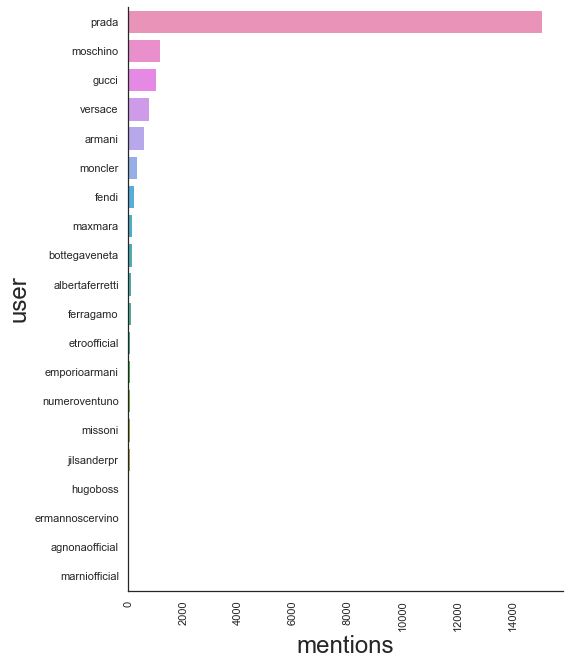

In [39]:
g = sns.catplot(x="mentions", y='user', hue='mentions',
            kind="bar", dodge=False,data=mfw_most_mentioned)
g.fig.set_size_inches(10,10)
g.set_xticklabels(rotation=90)
g.savefig("aggregated_mentions.png")

This clearly is not a good way to visualize the number of mentions,although it points out quite nicely the difference in the number of mentions between prada and the other brands. We use a logarithmic scale on the x axis. 

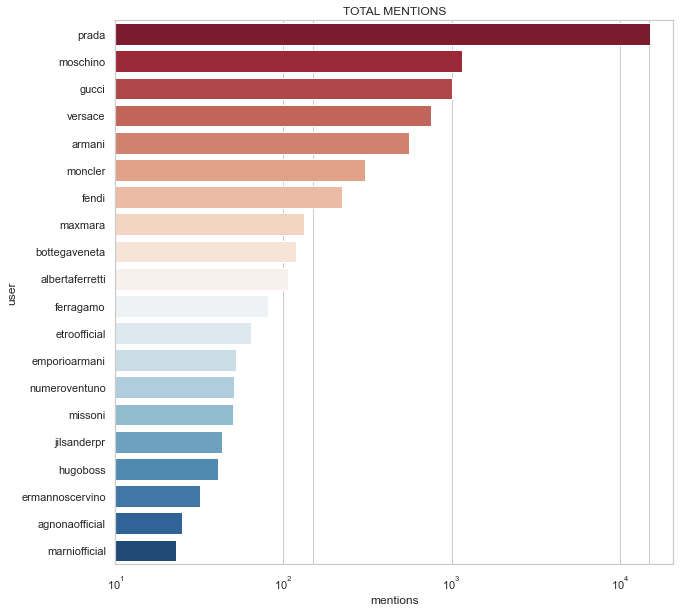

In [40]:
from numpy import median, var

plt.figure(figsize=(10,10))
sns.set(style='whitegrid')
g = sns.barplot(x="mentions", y='user', palette='RdBu', estimator=np.sum,
                ci=None, order=mfw_most_mentioned['user'], data=mfw_mention)
g.set_xscale('log')
plt.xticks(np.array([10,100,150,1000,10000,15000]))
plt.title('TOTAL MENTIONS')
plt.savefig("total_mentions_log.png")

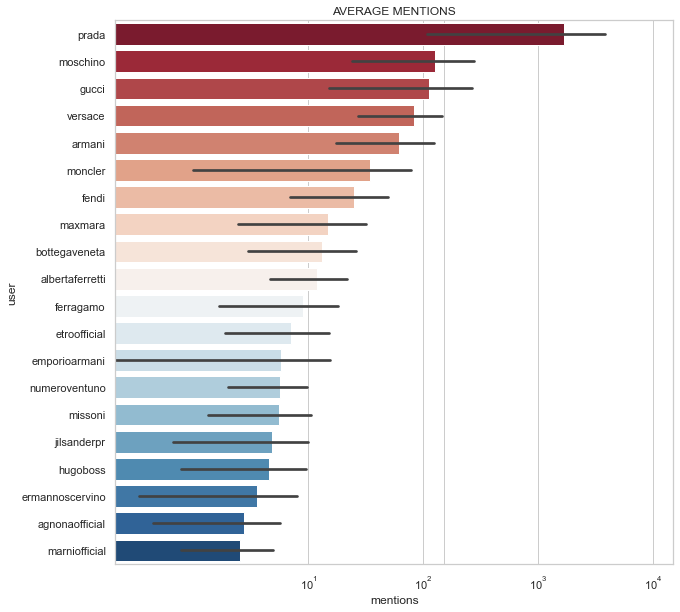

In [41]:
plt.figure(figsize=(10,10))
sns.set(style='whitegrid')
g = sns.barplot(x="mentions", y='user', palette='RdBu', estimator=np.mean,
                order=mfw_most_mentioned['user'], data=mfw_mention)
g.set_xscale('log')
plt.xticks(np.array([10,100,150,1000,10000,15000]))
plt.title('AVERAGE MENTIONS')
plt.savefig('avg_mentions_log.png')

Let's analyze the time series of the mentions for the brands:

In [42]:
mfw_mention['day'] = mfw_mention['date'].map(lambda x: x.day)

def eventDAY(d,u):
    if d == milan_brands[milan_brands['TWITTER'] == u]['DAY'].values[0]:
        return True
    else:
        return False
    
mfw_mention['event_day'] = np.vectorize(eventDAY)(mfw_mention['day'], mfw_mention['user'])


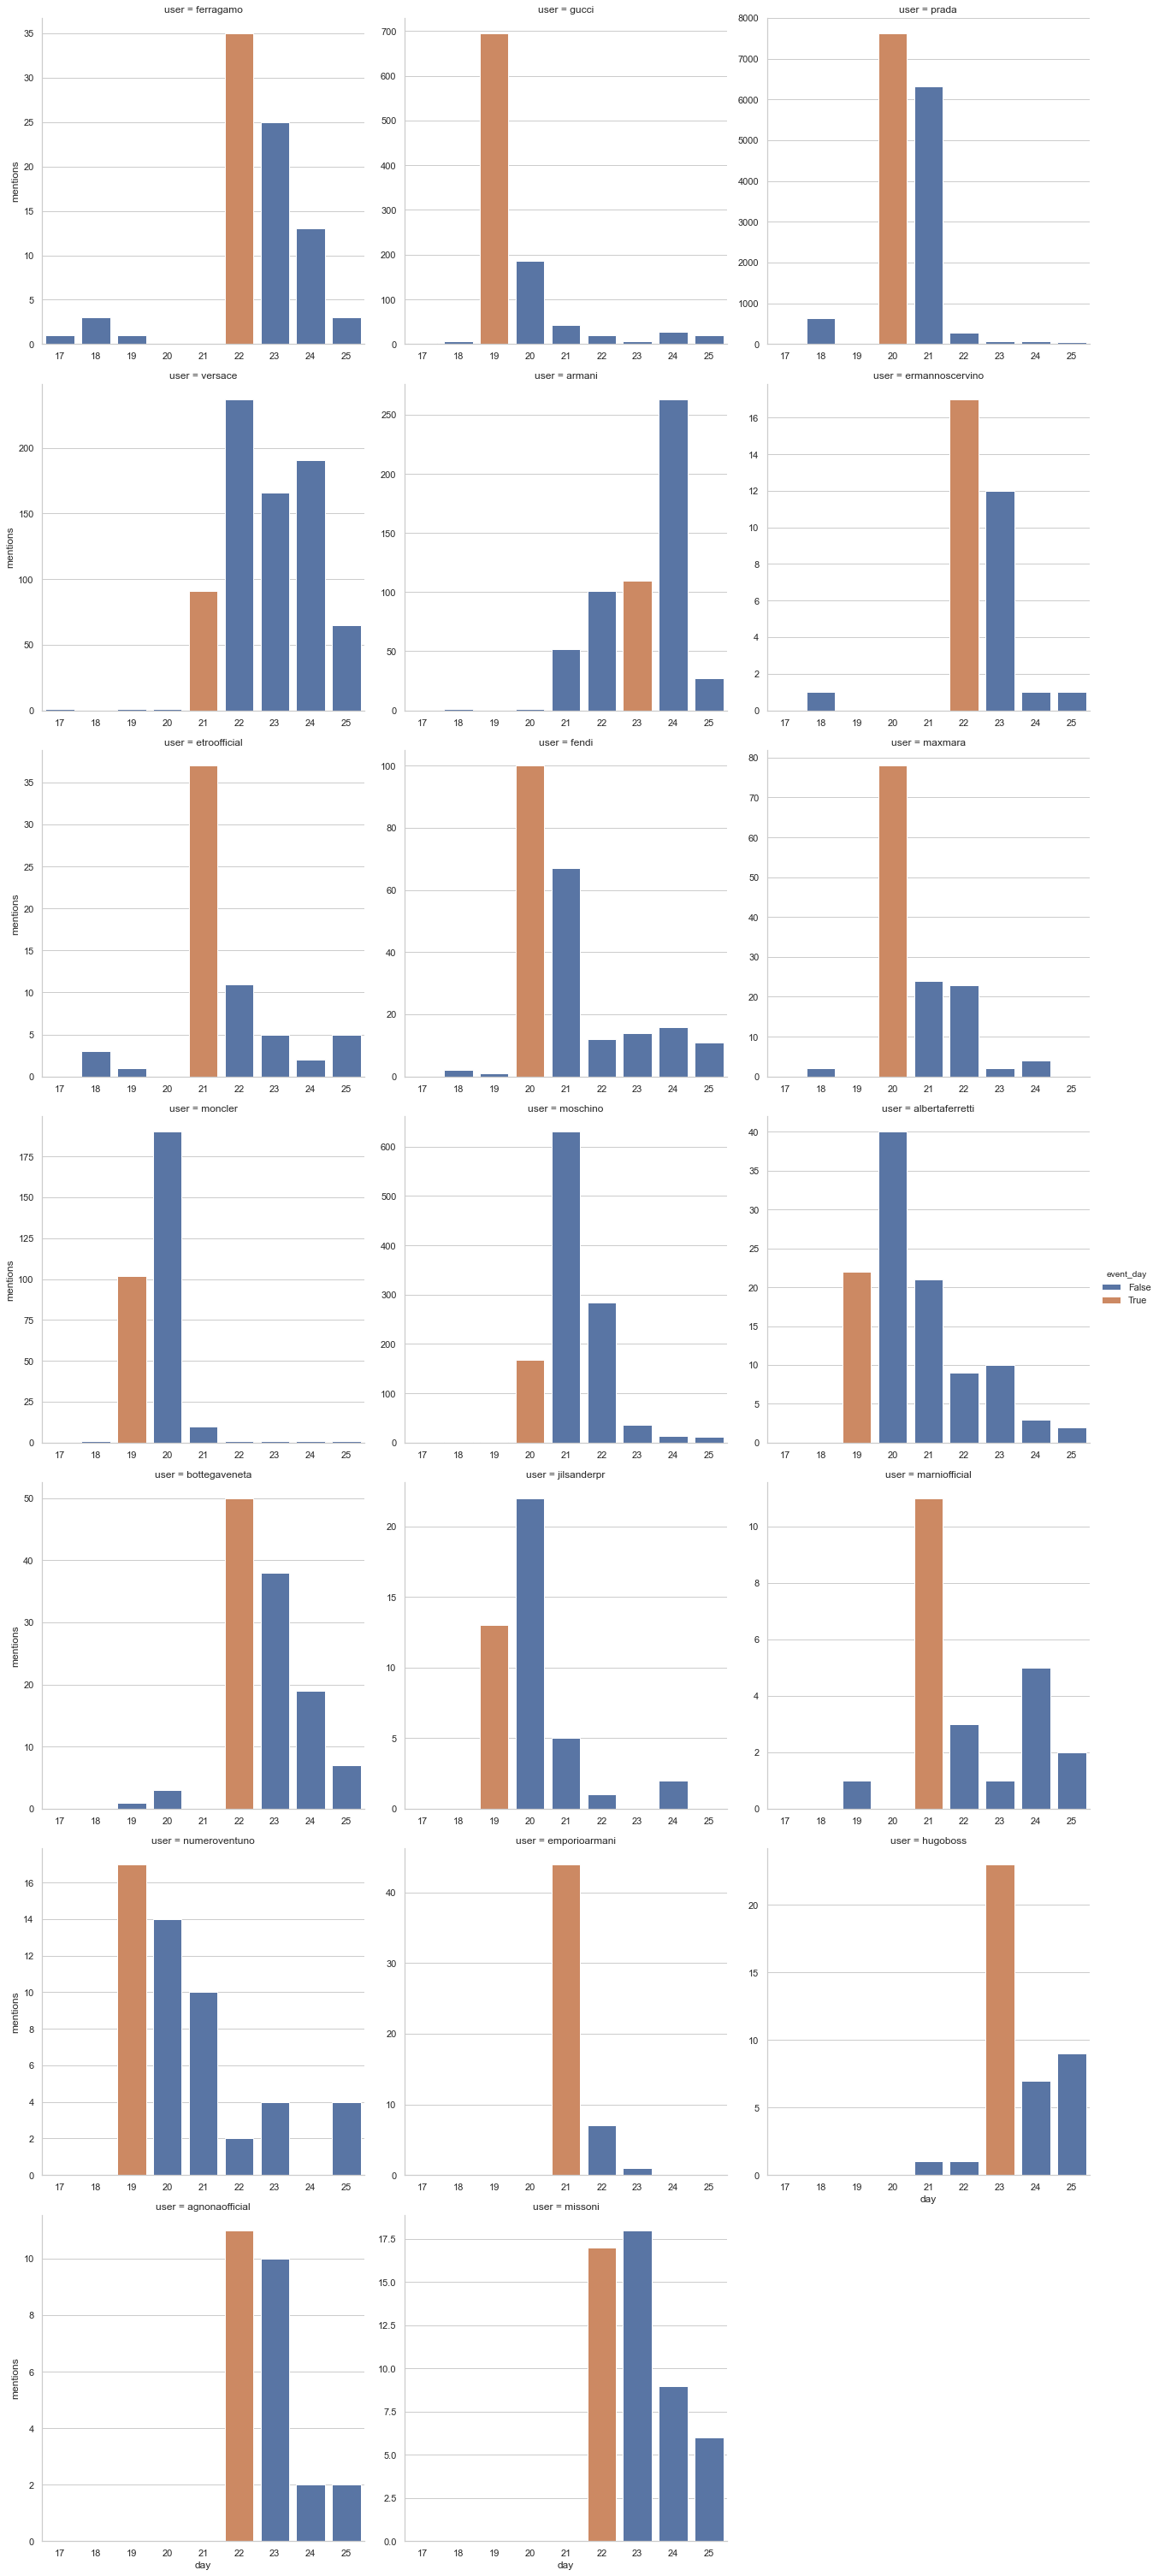

In [43]:
ts = sns.catplot(x="day", y='mentions', hue='event_day', col='user', col_wrap=3,
            height=6, aspect=1, sharey=False, sharex=False, 
            kind="bar", dodge=False, data=mfw_mention)
ts.savefig("time_series.png")

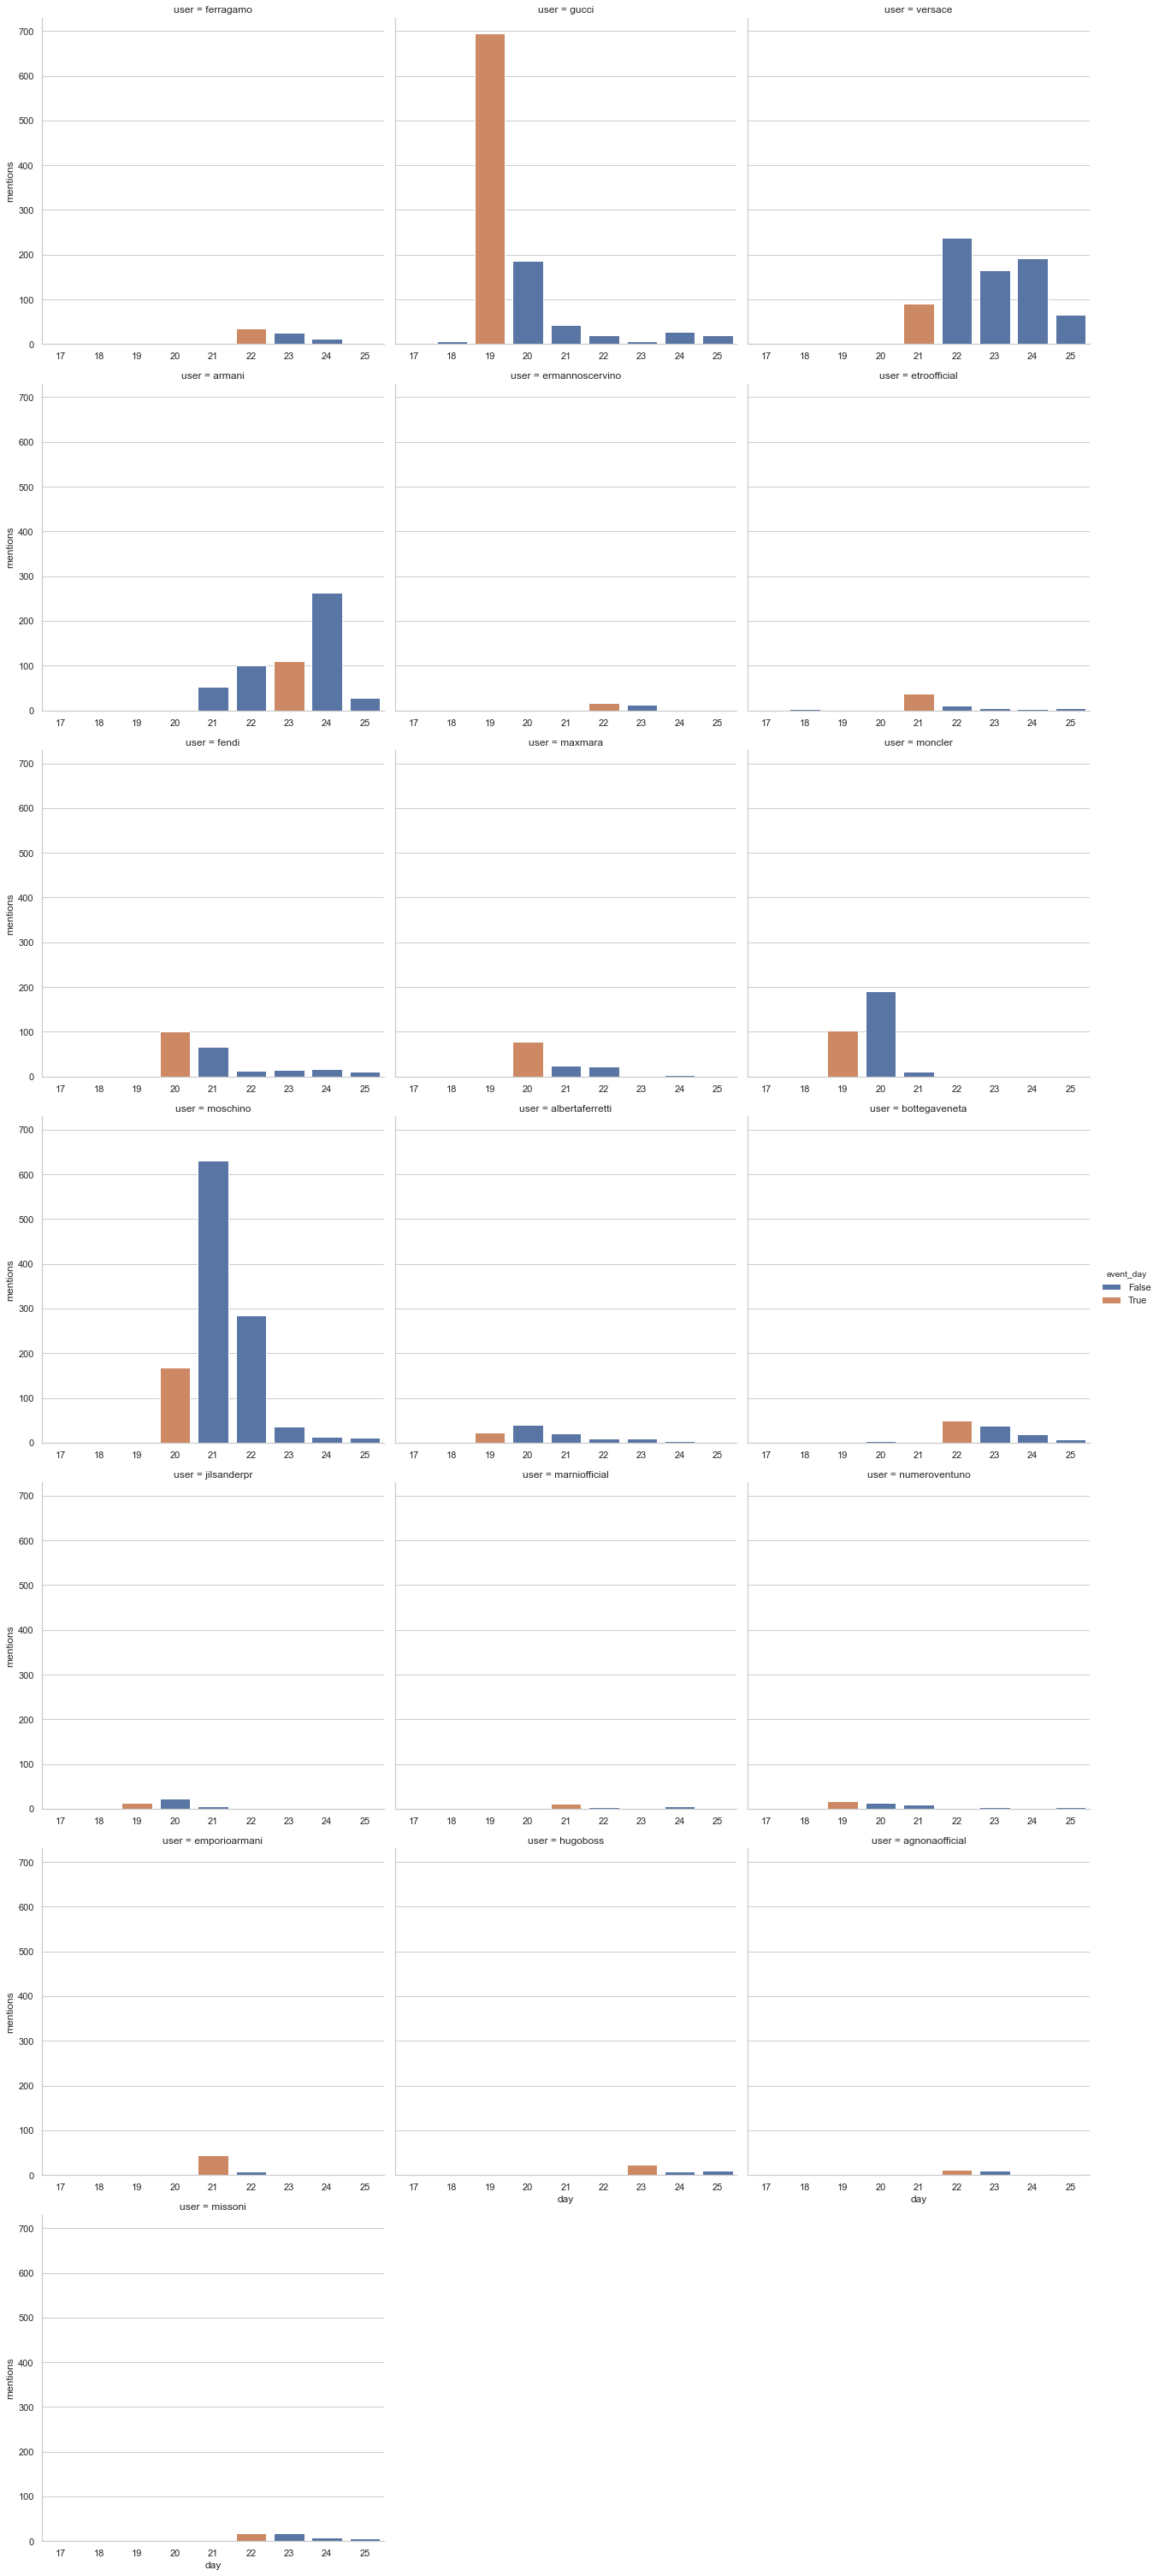

In [44]:
ts_fixedy = sns.catplot(x="day", y='mentions', hue='event_day', col='user', col_wrap=3,
            height=6, aspect=1, sharey=True, sharex=False, 
            kind="bar", dodge=False, data=mfw_mention[mfw_mention['user'] != 'prada'])
ts_fixedy.savefig("time_series_fixedy.png")

For all brands, we can see that the event is a driver of mentions, as expected. The highest peak is obtained within one day from the date of the event. 

# An interesting case to analyze is that of Prada.
It is the one with the most mentions, by far larger than the other brands (10x). Let's try to understand why.

## Let's preprocess the data

We pivot the table by turning the user rows into columns, and by leaving as rows only the days of the fashion week.
Once we have the pivoted table, we can compute the <i>Euclidean distance</i> between the different users, based on the time series of the mentions. We will do this with and without z-score normalization.
We are also going to compute the <i> Pearson Correlation </i> between the different users. 

In [55]:
most_mentioned

,index,user,mentions,tweets
0,102505,poshmarkapp,73074,0
1,102504,ygofficialblink,22792,0
2,102503,prada,15073,1
3,102502,originalfunko,11580,0
4,102501,britishvogue,6874,30
...,...,...,...,...
736,101791,catrionaelisa,21,0
737,101795,saru_maini,21,2
738,101796,wfto_fairtrade,21,0
739,101797,trf_stories,21,1


In [45]:
pivoted = user_mention[user_mention['user'].isin(most_mentioned['user'])].pivot(index='date', columns='user', values='mentions').reset_index()
pivoted.columns.name=None
pivoted

,date,0318st___,1313sem,1984recordings,365connections,5stocksinto,70s_fashion,80sthen80snow,_allisonnoelle,_iuofficial,...,yulia66880882,yuma_cherrsee,zalesjewelers,zarula57,zazzle,zdboutique,zhanzhanth_fc,zheedstore,zuviflavious,…
0,2020-02-17,53,6,0,0,10,8,22,0,0,...,4,12,0,2,7,2,0,4,0,7
1,2020-02-18,0,4,0,4,18,4,13,0,7,...,1,2,0,4,6,2,0,0,0,16
2,2020-02-19,0,6,0,15,17,4,0,9,4,...,1,0,0,2,6,1,0,0,0,4
3,2020-02-20,0,13,0,2,11,7,0,2,980,...,3,0,0,2,9,0,0,12,0,23
4,2020-02-21,0,2,0,0,16,4,1,2,82,...,2,7,0,1,15,18,0,8,0,6
5,2020-02-22,0,15,1,0,9,11,3,0,11,...,2,1,0,6,10,5,55,12,0,11
6,2020-02-23,0,14,16,0,13,10,7,10,4,...,7,1,0,6,8,1,1,28,0,7
7,2020-02-24,0,4,20,0,19,6,0,11,14,...,2,0,0,5,22,1,3,20,12,10
8,2020-02-25,0,5,2,0,21,5,0,0,3,...,2,0,21,0,10,6,0,8,36,21


### We compute the euclidean distance between the different users' time series

We compute it non-normalized first.

In [46]:
from scipy.spatial import distance
distance_euclidean = distance.cdist(pivoted[pivoted.columns[1:]].to_numpy().T,pivoted[pivoted.columns[1:]].to_numpy().T,'euclidean')
distance_euclidean_df = pd.DataFrame(data=distance_euclidean, columns=pivoted.columns[1:], index=pivoted.columns[1:])

In [47]:
distance_euclidean_df

,0318st___,1313sem,1984recordings,365connections,5stocksinto,70s_fashion,80sthen80snow,_allisonnoelle,_iuofficial,_joyo903,...,yulia66880882,yuma_cherrsee,zalesjewelers,zarula57,zazzle,zdboutique,zhanzhanth_fc,zheedstore,zuviflavious,…
0318st___,0.000000,53.814496,58.906706,55.263008,62.377881,49.030603,34.481879,55.848008,985.058374,64.070274,...,49.769469,41.665333,57.008771,52.182373,56.938563,54.708317,76.446059,63.253458,65.184354,60.530984
1313sem,53.814496,0.000000,26.944387,26.532998,32.419130,9.165151,27.874720,22.293497,970.442167,41.605288,...,19.209373,26.000000,30.886890,18.027756,24.494897,27.367864,45.343136,23.727621,41.315857,24.939928
1984recordings,58.906706,26.944387,0.000000,30.099834,39.051248,22.405357,33.808283,14.525839,983.600529,44.237993,...,20.904545,28.740216,31.906112,19.570386,25.298221,30.838288,58.600341,22.912878,38.431758,39.089641
365connections,55.263008,26.532998,30.099834,0.000000,41.097445,22.538855,29.206164,16.643317,981.672043,35.397740,...,16.941074,20.688161,26.191602,16.462078,34.000000,24.392622,57.271284,42.579338,41.048752,38.755645
5stocksinto,62.377881,32.419130,39.051248,41.097445,0.000000,31.096624,40.963398,36.878178,971.669182,46.281746,...,39.698866,41.964271,41.243181,38.548671,20.856654,37.549967,63.616036,33.436507,40.174619,23.388031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zdboutique,54.708317,27.367864,30.838288,24.392622,37.549967,20.904545,29.799329,23.958297,982.220444,39.344631,...,18.220867,16.583124,24.186773,19.390719,26.210685,0.000000,53.600373,37.363083,37.148351,35.791060
zhanzhanth_fc,76.446059,45.343136,58.600341,57.271284,63.616036,47.031904,58.335238,57.087652,984.512062,65.810334,...,53.674948,55.874860,58.957612,49.588305,54.424259,53.600373,0.000000,56.169387,66.355105,57.861905
zheedstore,63.253458,23.727621,22.912878,42.579338,33.436507,24.879711,40.890097,29.086079,971.194625,53.962950,...,31.937439,39.076847,41.484937,31.336879,23.473389,37.363083,56.169387,0.000000,44.721360,33.421550
zuviflavious,65.184354,41.315857,38.431758,41.048752,40.174619,37.134889,46.389654,38.548671,984.082822,52.306787,...,36.606010,40.484565,19.209373,38.026307,36.972963,37.148351,66.355105,44.721360,0.000000,35.846897


In [48]:
distance_euclidean_df['prada'].sort_values()[0:10]

prada                 0.000000
britishvogue       5514.748861
ygofficialblink    5973.668806
hypebae            7135.400479
chinadaily         7832.100293
ygent_official     8012.131052
gettyimages        8053.522087
emrata             8078.461302
charlidamelio      8089.023118
edam_ent           8408.169658
Name: prada, dtype: float64

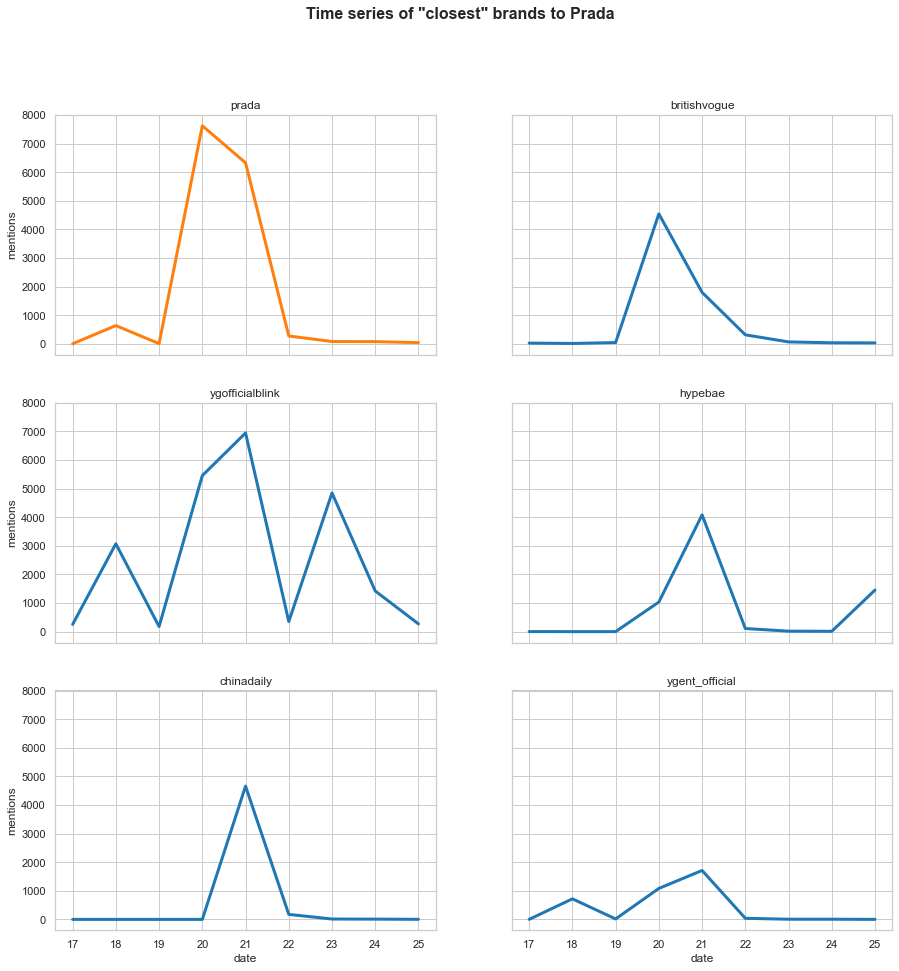

In [49]:
#obtain the name of the users to plot and their time series
users_toplot = distance_euclidean_df['prada'].sort_values()[0:6].index
series = pivoted[users_toplot].to_numpy()

#create the subplots
fig, axs = plt.subplots(3, 2, figsize=(15,15), sharey=True)
fig.suptitle('Time series of "closest" brands to Prada', fontsize=16, fontweight='bold')

#cicle over the subplots and plot their time series 
i = 0
for j in range(len(axs)):
    for k in range(len(axs[j])):
        
        s = series[:,i]
        
        if(users_toplot[i] == 'prada'):
            sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:orange')
        
        else:
            sp = sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:blue')
        axs[j,k].set_title(users_toplot[i])
        i+=1
   
for ax in axs.flat:
    ax.set(xlabel='date', ylabel='mentions')

for ax in axs.flat:
    ax.label_outer()

# Display a figure.
plt.show()

fig.savefig('distance_timeseries.png')

We know, from domain knowledge, that a member of K-POP band BLACKPINK, Lisa, has taken part to the prada event at the fashion week. This would justify the presence of:
- <i><b>@ygofficialblink</b></i>, which is the official account of BLACKPINK
- <i><b>@ygent_official</b></i>, which is the record label to whom BLACKPINk belong

It might also justify the presence of <i><b>@chinadaily</b></i>, given by the fact that it could've reported the news about blackpink, or something like that, but this would have to be furtherly analysed in order to understand the reason why. 

The same deeper analysis should be conducted also for <i><b>@hypebae</b></i> and <i><b>@britishvogue</b></i>, both magazines.

### Let's to compute the correlation between the time series

In [50]:
corrmat = pivoted.corr()
corrmat['prada'].sort_values(ascending=False)[0:10]

prada              1.000000
melbemol           0.995937
nhfasharchive      0.995307
pierreyvesrevaz    0.993303
ogata_photo        0.992204
capackermann       0.983159
saweetiedaily      0.981611
instyle            0.981164
meenavoguee        0.977154
fendi              0.972716
Name: prada, dtype: float64

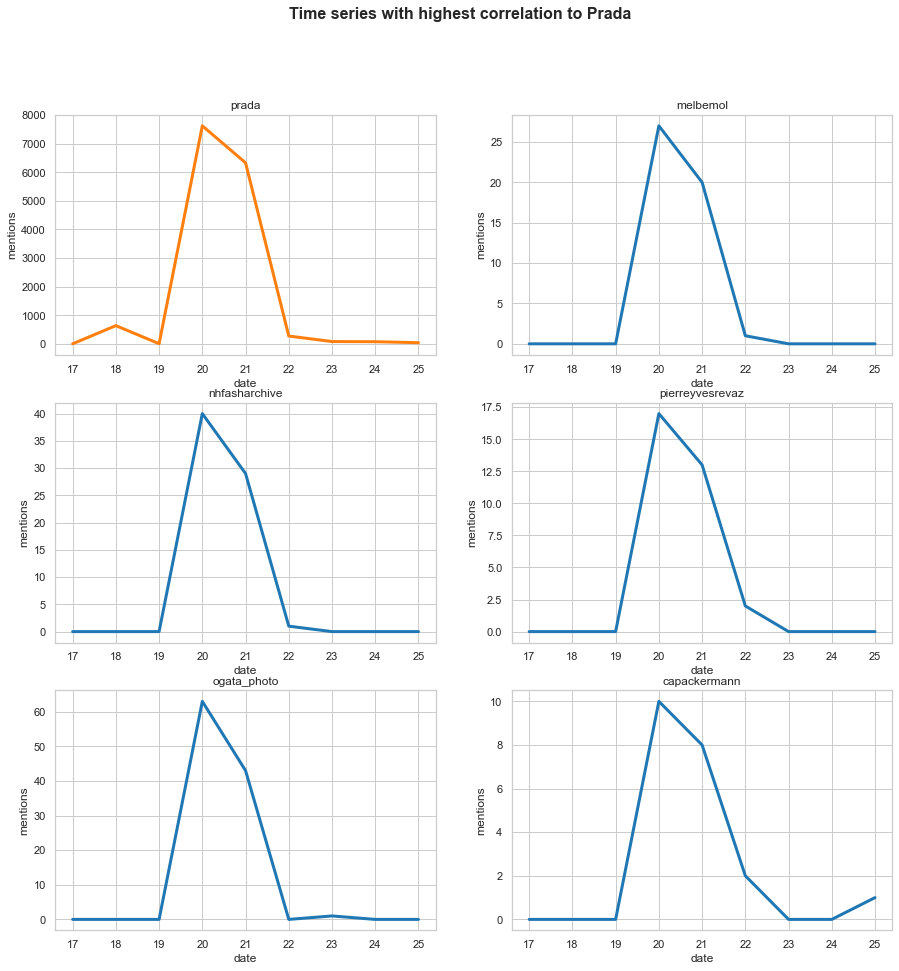

In [51]:
#obtain the name of the users to plot and their time series
users_toplot = corrmat['prada'].sort_values(ascending=False)[0:6].index
series = pivoted[users_toplot].to_numpy()

#create the subplots
fig, axs = plt.subplots(3, 2, figsize=(15,15), sharey=False)
fig.suptitle('Time series with highest correlation to Prada', fontsize=16, fontweight='bold')

#cicle over the subplots and plot their time series 
i = 0
for j in range(len(axs)):
    for k in range(len(axs[j])):
        
        s = series[:,i]
        
        if(users_toplot[i] == 'prada'):
            sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:orange')
        
        else:
            sp = sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:blue')
        axs[j,k].set_title(users_toplot[i])
        i+=1
   
for ax in axs.flat:
    ax.set(xlabel='date', ylabel='mentions')

# Display a figure.
plt.show()
fig.savefig('correlation_timeseries.png')

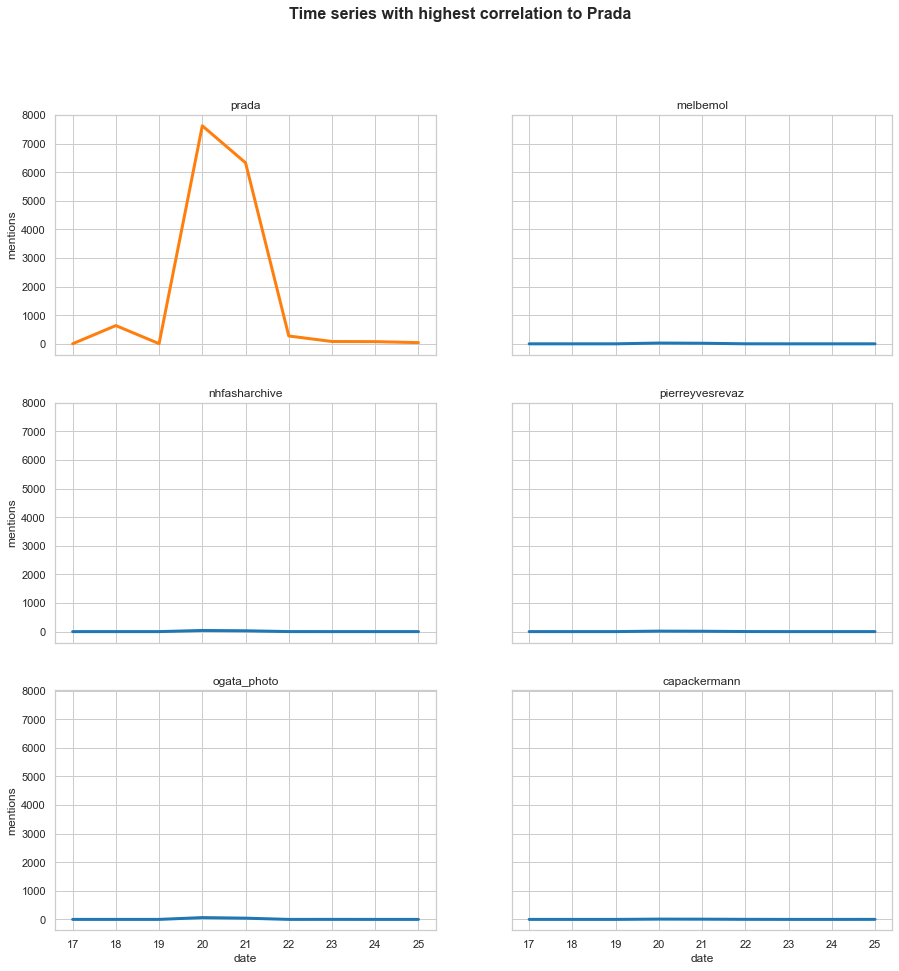

In [52]:

#create the subplots
fig, axs = plt.subplots(3, 2, figsize=(15,15), sharey=True)
fig.suptitle('Time series with highest correlation to Prada', fontsize=16, fontweight='bold')

#cicle over the subplots and plot their time series 
i = 0
for j in range(len(axs)):
    for k in range(len(axs[j])):
        
        s = series[:,i]
        
        if(users_toplot[i] == 'prada'):
            sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:orange')
        
        else:
            sp = sp = axs[j,k].plot(mfw_mention[mfw_mention['user']=='prada']['day'], s,
                linewidth=3, color='tab:blue')
        axs[j,k].set_title(users_toplot[i])
        i+=1
   
for ax in axs.flat:
    ax.set(xlabel='date', ylabel='mentions')

for ax in axs.flat:
    ax.label_outer()

# Display a figure.
plt.show()
fig.savefig('correlation_timeseries_fixedy.png')

The next steps will be: 
- Understanding if the similarity in the time series of prada with the other users is given by the fact that they're mentioned in the same tweets, or if they're mentioned about the same topic